# **Waste Classification**
Classifying waste as organic or recyclable from images using convolution neural networks and transfer learning

> **Dataset:** https://www.kaggle.com/techsash/waste-classification-data

> **Tips**
*   upload the datasets as a zip file named 'waste classification' into tmp folder
*   to decrease training time, turn on GPU accelerator within notebook settings
*   the original dataset has more organic image samples than recyclable image samples for both the training and validation sets. To fix this, I manually trimmed the organic datasets within file explorer (organized by descending file size for a more randomized ordering than alphanumeric)

> **References**
*   https://developers.google.com/machine-learning/practica/image-classification?hl=en
*   https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/?completed=/introduction-deep-learning-python-tensorflow-keras/
*   https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/



# Data set-up

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
!kaggle datasets download -d techsash/waste-classification-data

Dataset URL: https://www.kaggle.com/datasets/techsash/waste-classification-data
License(s): CC-BY-SA-4.0
 99% 424M/427M [00:03<00:00, 178MB/s]
100% 427M/427M [00:03<00:00, 142MB/s]


In [ ]:
import zipfile
import os

# extracting the contents of the zip file
local_zip = 'waste-classification-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

In [21]:
base_dir = 'DATASET'
train_dir = os.path.join(base_dir, 'TRAIN')
validation_dir = os.path.join(base_dir, 'TEST')

# Directory with training organic pictures
train_organic_dir = os.path.join(train_dir, 'O')

# Directory with training recyclable pictures
train_recycle_dir = os.path.join(train_dir, 'R')

# Directory with validation organic pictures
validation_organic_dir = os.path.join(validation_dir, 'O')

# Directory with validation recyclable pictures
validation_recycle_dir = os.path.join(validation_dir, 'R')

print('total training organic images:', len(os.listdir(train_organic_dir)))
print('total training recycyle images:', len(os.listdir(train_recycle_dir)))
print('total validation organic images:', len(os.listdir(validation_organic_dir)))
print('total validation recycyle images:', len(os.listdir(validation_recycle_dir)))

total training organic images: 12565
total training recycyle images: 9999
total validation organic images: 1401
total validation recycyle images: 1112


(198, 254, 3)
(168, 300, 3)
(225, 225, 3)
(194, 259, 3)
(160, 314, 3)
(150, 300, 3)
(187, 269, 3)
(168, 300, 3)


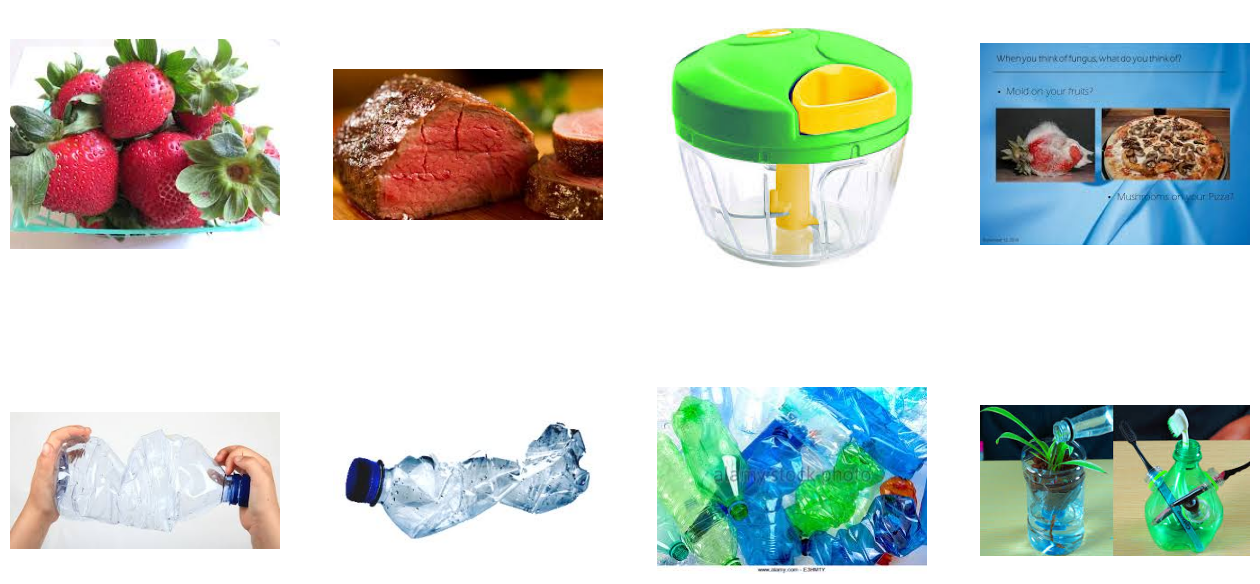

In [22]:
train_organic_fnames = os.listdir(train_organic_dir)
train_recycle_fnames = os.listdir(train_recycle_dir)
train_recycle_fnames.sort()

%matplotlib inline

# Parameters for our graph; we'll output images in a 2x4 configuration
nrows = 2
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 2x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows *4)

pic_index += 4
next_organic_pix = [os.path.join(train_organic_dir, fname)
                for fname in train_organic_fnames[pic_index-4:pic_index]]
next_recycle_pix = [os.path.join(train_recycle_dir, fname)
                for fname in train_recycle_fnames[pic_index-4:pic_index]]

for i, img_path in enumerate(next_organic_pix + next_recycle_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  print(img.shape)

plt.show()

# Data pre-processing

In [23]:
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [24]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,               # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        shuffle=True,
        class_mode='binary')

# Flow validation images in batches of 20 using val_datagen generator
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        shuffle=True,
        class_mode='binary')

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


# Building the machine learning model

## Trial 1

*   set-up based on ML Practicum: Image Classification Exercise 1/2 by Google (ref. https://developers.google.com/machine-learning/practica/image-classification/exercise-1?hl=en)

In [25]:
# Our input feature map is 150x150x3: 150x150 for the image pixels, and 3 for
# the three color channels: R, G, and B
img_input = layers.Input(shape=(150, 150, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# Create model:
# input = input feature map
# output = input feature map + stacked convolution/maxpooling layers + fully
# connected layer + sigmoid output layer
model = Model(img_input, output)

In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 17, 17, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 18496)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       9,470,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['acc'])

history = model.fit(
      train_generator,
      epochs=8,
      validation_data=validation_generator,
      verbose=2,
      shuffle=True)

Epoch 1/8


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


706/706 - 36s - 51ms/step - acc: 0.7966 - loss: 0.4658 - val_acc: 0.8170 - val_loss: 0.4098
Epoch 2/8
706/706 - 33s - 47ms/step - acc: 0.8437 - loss: 0.3763 - val_acc: 0.8922 - val_loss: 0.2887
Epoch 3/8
706/706 - 27s - 38ms/step - acc: 0.8581 - loss: 0.3410 - val_acc: 0.8766 - val_loss: 0.3093
Epoch 4/8
706/706 - 41s - 58ms/step - acc: 0.8718 - loss: 0.3192 - val_acc: 0.9037 - val_loss: 0.2609
Epoch 5/8
706/706 - 42s - 60ms/step - acc: 0.8825 - loss: 0.2898 - val_acc: 0.8894 - val_loss: 0.2779
Epoch 6/8
706/706 - 40s - 56ms/step - acc: 0.8966 - loss: 0.2632 - val_acc: 0.8989 - val_loss: 0.2713
Epoch 7/8
706/706 - 27s - 38ms/step - acc: 0.9106 - loss: 0.2305 - val_acc: 0.8850 - val_loss: 0.3407
Epoch 8/8
706/706 - 26s - 37ms/step - acc: 0.9256 - loss: 0.1976 - val_acc: 0.8890 - val_loss: 0.3030


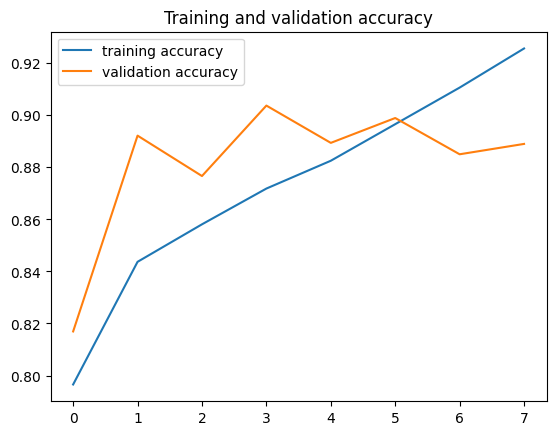

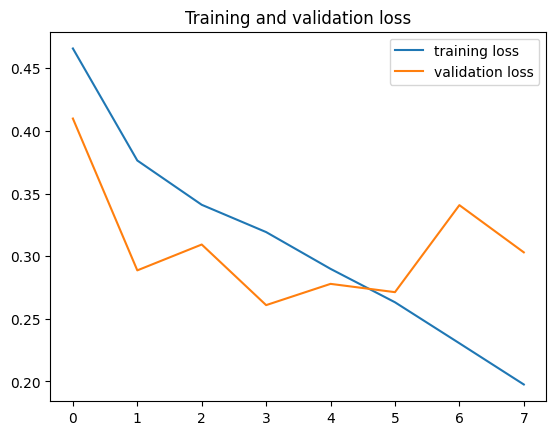

In [31]:
#@title Graphing accuracy and loss
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

## Trial 2 - Transfer Learning

*   set-up based on ML Practicum: Image Classification Exercise 3 by Google (ref. https://developers.google.com/machine-learning/practica/image-classification/exercise-3?hl=en)
*   this model makes use of the Inception V3 model developed at Google which is pre-trained on ImageNet, a large dataset of web images




In [33]:
# loading in the Inception v3 model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5


from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import SGD

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)


for layer in pre_trained_model.layers:
  layer.trainable = False


last_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

--2024-10-03 15:27:04--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 108.177.98.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   167MB/s    in 0.5s    

2024-10-03 15:27:05 (167 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [35]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

unfreeze = False

# Unfreeze all models after "mixed6"
for layer in pre_trained_model.layers:
  if unfreeze:
    layer.trainable = True
  if layer.name == 'mixed6':
    unfreeze = True

# Configure the model
model = Model(pre_trained_model.input, x)

# As an optimizer, here we will use SGD
# with a very low learning rate (0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(
                  learning_rate=0.00001,
                  momentum=0.9),
              metrics=['acc'])

In [36]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_100 (Conv2D)       │ (None, 74, 74, 32)     │            864 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, 74, 74, 32)     │             96 │ conv2d_100[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 74, 74, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_101 (Conv2D)       │ (None, 72, 72, 32)     │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, 72, 72, 32)     │             96 │ conv2d_101[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 72, 72, 32)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 72, 72, 64)     │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, 72, 72, 64)     │            192 │ conv2d_102[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 72, 72, 64)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 35, 35, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_103 (Conv2D)       │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, 35, 35, 80)     │            240 │ conv2d_103[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 35, 35, 80)     │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_104 (Conv2D)  

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 40,677,249 (155.17 MB)

 Non-trainable params: 6,835,232 (26.07 MB)

In [38]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=60,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/60
100/100 - 28s - 284ms/step - acc: 0.5100 - loss: 0.7155 - val_acc: 0.5575 - val_loss: 0.6878
Epoch 2/60
100/100 - 9s - 86ms/step - acc: 0.5581 - loss: 0.6869 - val_acc: 0.6199 - val_loss: 0.6580
Epoch 3/60


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 - 5s - 53ms/step - acc: 0.6056 - loss: 0.6668 - val_acc: 0.6438 - val_loss: 0.6398
Epoch 4/60
100/100 - 8s - 85ms/step - acc: 0.6250 - loss: 0.6464 - val_acc: 0.6648 - val_loss: 0.6290
Epoch 5/60
100/100 - 14s - 135ms/step - acc: 0.6702 - loss: 0.6277 - val_acc: 0.6969 - val_loss: 0.6079
Epoch 6/60
100/100 - 8s - 84ms/step - acc: 0.6828 - loss: 0.6054 - val_acc: 0.6857 - val_loss: 0.5940
Epoch 7/60
100/100 - 6s - 55ms/step - acc: 0.7091 - loss: 0.5912 - val_acc: 0.6975 - val_loss: 0.5853
Epoch 8/60
100/100 - 1s - 12ms/step - acc: 0.7552 - loss: 0.5703 - val_acc: 0.7251 - val_loss: 0.5723
Epoch 9/60
100/100 - 7s - 67ms/step - acc: 0.7303 - loss: 0.5760 - val_acc: 0.7306 - val_loss: 0.5678
Epoch 10/60
100/100 - 5s - 46ms/step - acc: 0.7522 - loss: 0.5613 - val_acc: 0.7623 - val_loss: 0.5547
Epoch 11/60
100/100 - 5s - 54ms/step - acc: 0.7453 - loss: 0.5594 - val_acc: 0.7738 - val_loss: 0.5398
Epoch 12/60
100/100 - 6s - 57ms/step - acc: 0.7666 - loss: 0.5384 - val_acc: 0.7700 - val

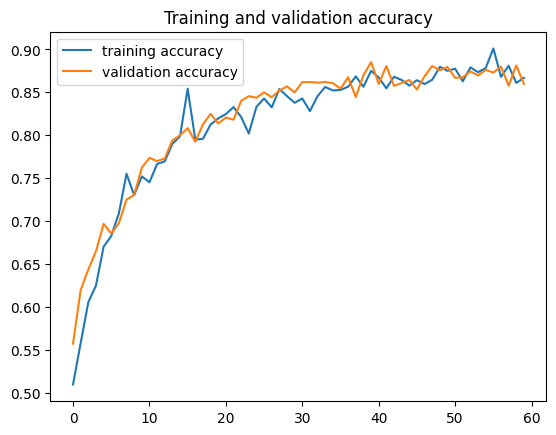

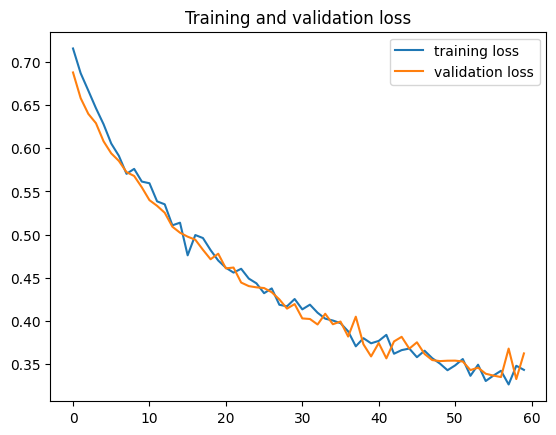

In [39]:
#@title Graphing accuracy and loss
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.title('Training and validation loss')
plt.legend()

# From scratch - Evaluating model performance + Visualizing results

## Visualizing predictions

Displaying the result of using the machine learning model created to classify waste samples within the validation set

In [40]:
# Flow validation images using val_datagen generator
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 2513 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [41]:
val_pred_prob = model.predict(val_visual)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step


In [42]:
# must get index array before getting predictions!
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'

# getting predictions in the form of probablities
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
  misclassified_filepaths.append(val_visual.filepaths[dir_index])
  if pred_label != true_label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step
Model predictions: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1

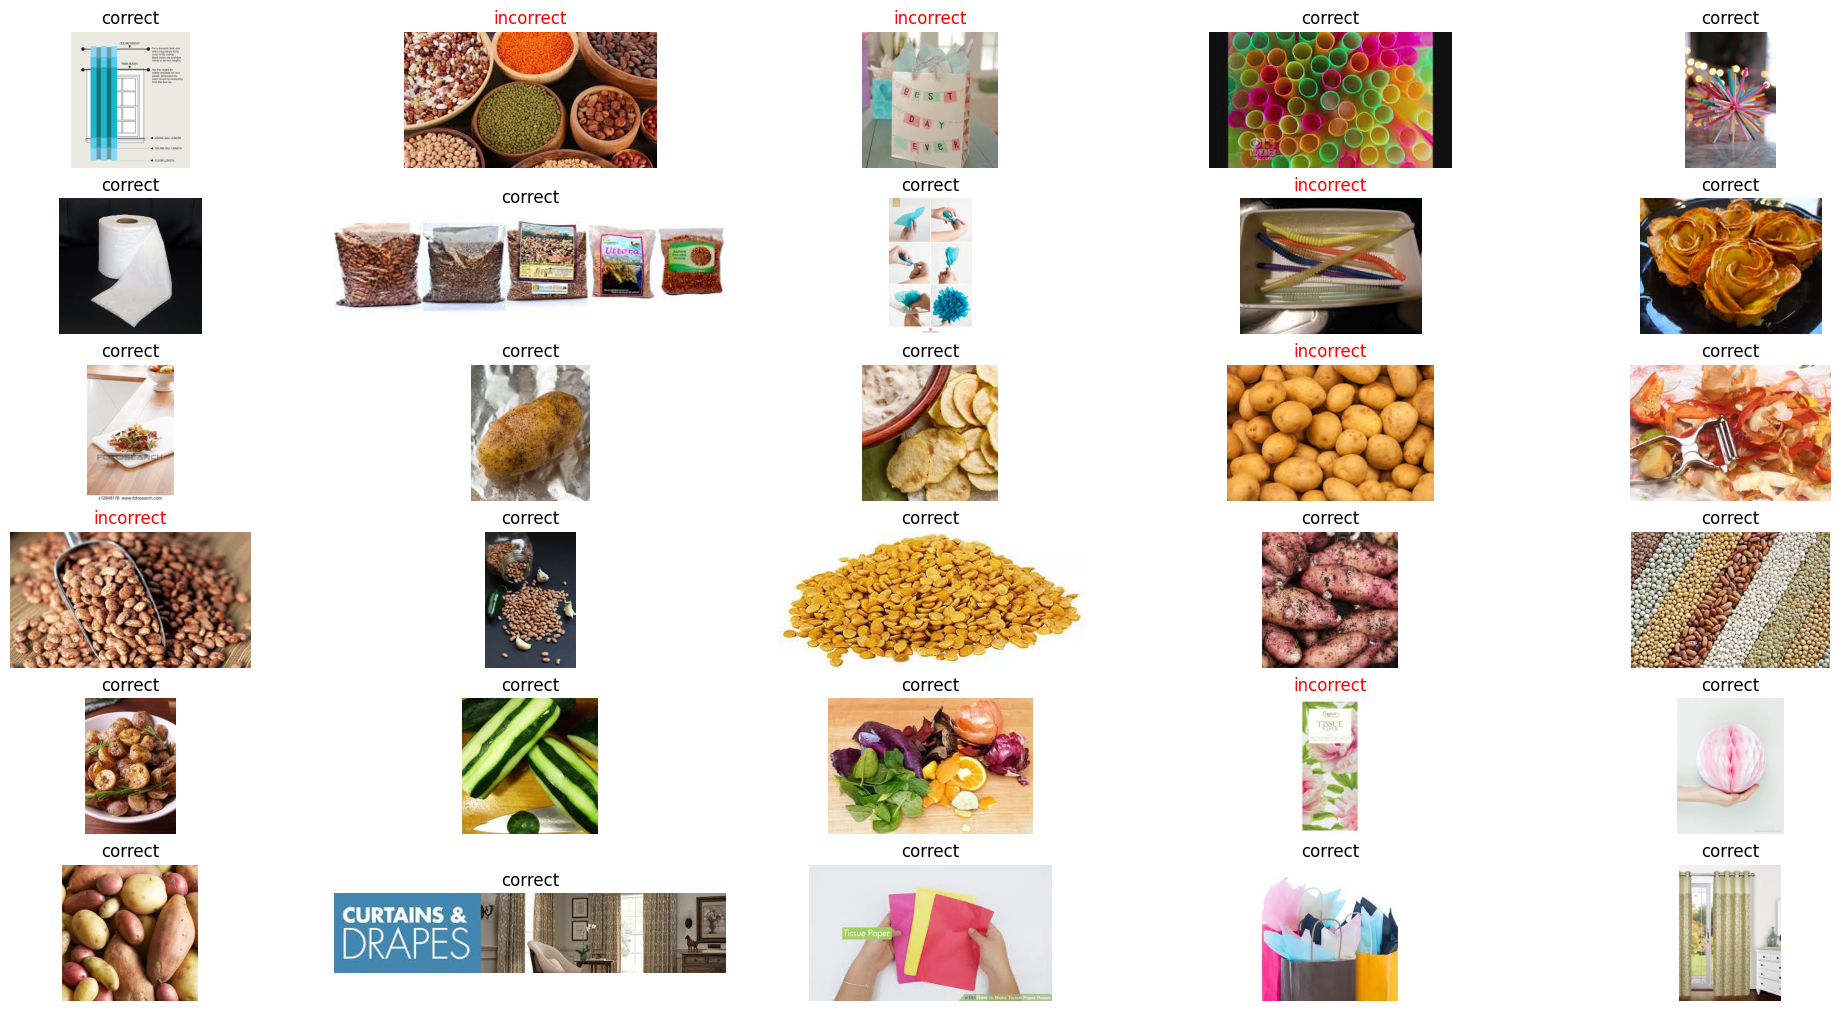

In [43]:
# obtaining the images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plots first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1
plt.show()

## Evaluating model performance using other metrics

In [44]:
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss))

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - acc: 0.8824 - loss: 0.3297
Accuracy using evaluate: 0.875447690486908
Loss using evaluate: 0.33674749732017517


In [45]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[1062   50]
 [ 516  885]] 

Outcome values : 
 885 516 50 1062 

Classification report : 
               precision    recall  f1-score   support

           1       0.95      0.63      0.76      1401
           0       0.67      0.96      0.79      1112

    accuracy                           0.77      2513
   macro avg       0.81      0.79      0.77      2513
weighted avg       0.83      0.77      0.77      2513



# From transfer learning - Evaluating model performance + Visualizing results

## Visualizing predictions

Displaying the result of using the machine learning model created to classify waste samples within the validation set

In [46]:
# Flow validation images using val_datagen generator
val_visual = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        class_mode='binary',
        shuffle=True)

print(val_visual.class_indices)

Found 2513 images belonging to 2 classes.
{'O': 0, 'R': 1}


In [47]:
val_pred_prob = model.predict(val_visual)

 5/79 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step


In [48]:
# must get index array before getting predictions!
val_dir_indices = val_visual.index_array
val_true_labels = [0 if n < 1112 else 1 for n in val_dir_indices] # directory is sorted alphanumerically; 1st 1112: 'O', 2nd 1112: 'R'

# getting predictions in the form of probablities
val_pred_prob = model.predict(val_visual)

# converting the probablities into binary values
val_pred_labels = [1 if n >= 0.5 else 0 for n in val_pred_prob]

print("Model predictions: "+str(val_pred_labels))
print("Actual labels:     "+str(val_true_labels))

# determining the filepaths of misclassified waste
num_misclasssified = 0
misclassified_filepaths = []
correctness = []
for pred_label, true_label, dir_index in zip(val_pred_labels, val_true_labels, val_visual.index_array):
  misclassified_filepaths.append(val_visual.filepaths[dir_index])
  if pred_label != true_label:
    correctness.append('incorrect')
    num_misclasssified += 1
  else:
    correctness.append('correct')

print("# of total images: "+str(len(correctness)))
print("# of misclassified images: "+str(num_misclasssified))

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step
Model predictions: [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0

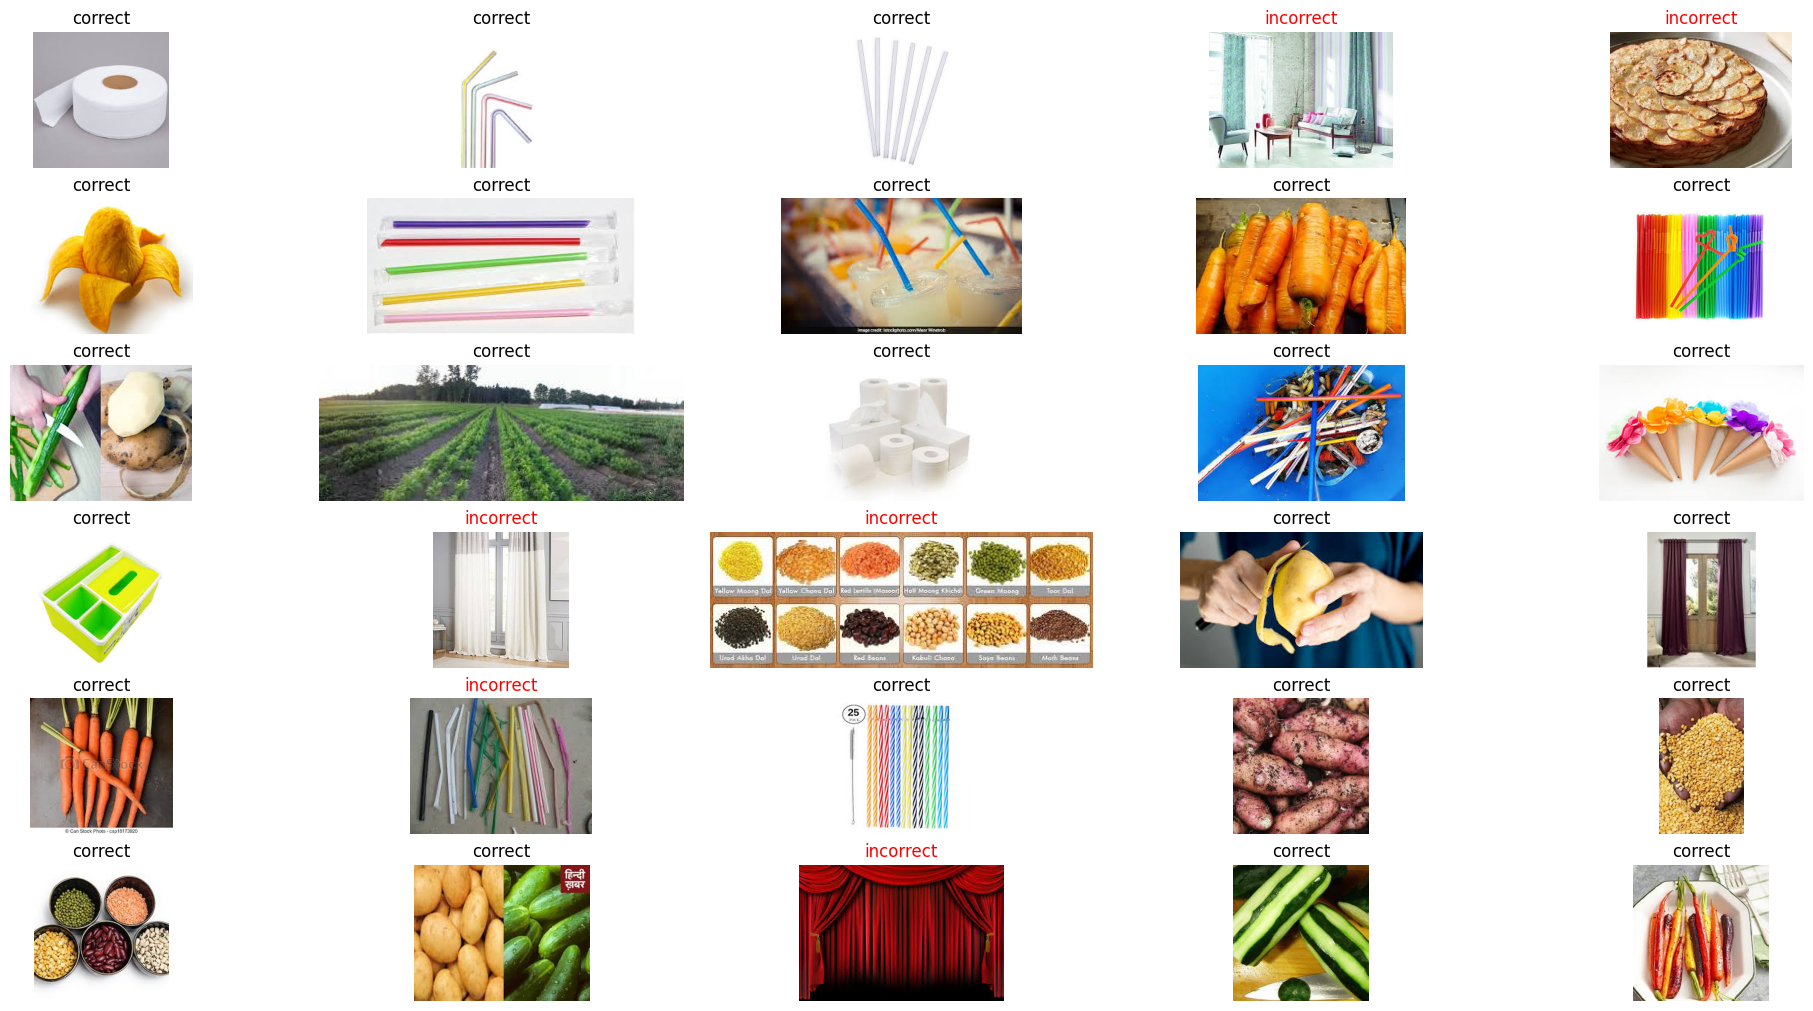

In [49]:
# obtaining the images from the filepath at the determined indices
misclassified_imgs = []
for filepath in misclassified_filepaths:
  misclassified_imgs.append(mpimg.imread(filepath))

# plots first 30 images
f, axarr = plt.subplots(6,5, figsize=(20,10), constrained_layout=True)  # plt.subplots(row,cols)
count = 0
for r in range(6):
  for c in range(5):
    axarr[r,c].imshow(misclassified_imgs[count])
    if correctness[count] == 'correct':
      axarr[r,c].set_title(correctness[count])
    else:
      axarr[r,c].set_title(correctness[count], color='red')
    axarr[r,c].set_axis_off()
    count += 1
plt.show()

## Evaluating model performance using other metrics

In [50]:
loss, acc = model.evaluate(validation_generator, verbose=1)
print("Accuracy using evaluate: "+str(acc))
print("Loss using evaluate: "+str(loss))

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - acc: 0.8754 - loss: 0.3300
Accuracy using evaluate: 0.875447690486908
Loss using evaluate: 0.33674749732017517


In [51]:
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# confusion matrix
matrix = confusion_matrix(val_true_labels, val_pred_labels, labels=[0, 1])
print('Confusion matrix : \n',matrix, '\n')

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(val_true_labels, val_pred_labels, labels=[1,0]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn, '\n')

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(val_true_labels, val_pred_labels, labels=[1,0])
print('Classification report : \n',matrix)

Confusion matrix : 
 [[1062   50]
 [ 516  885]] 

Outcome values : 
 885 516 50 1062 

Classification report : 
               precision    recall  f1-score   support

           1       0.95      0.63      0.76      1401
           0       0.67      0.96      0.79      1112

    accuracy                           0.77      2513
   macro avg       0.81      0.79      0.77      2513
weighted avg       0.83      0.77      0.77      2513



In [52]:
model.save('recycle.h5')


In [53]:
pip freeze > requirements.txt